In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from j2v import mag, w2v, util
from scipy.spatial.distance import cosine
%matplotlib inline

In [4]:
model = w2v.load_j2v('../data/100feat_50minwords_10context_2016')


model shape is: (20835, 100) 



In [5]:
mapping = mag.load_map_jid_discipline()

14113 journals in MAG's Journal.txt were matched to UCSD data, and 29 of them are interdisciplinary journals in UCSD catelog.


In [38]:
# get jid_2d_projection.csv file
w2v.compute_tsne_2D(model, mapping, perplexity = 50, rand_seed =1, theta= 0.5)

Among these vanues, 12780 are covered in the j2v model.

Computing t-SNE projection for these journal vectors...

2d projection points have written to file: jid_2d_projection.csv


In [6]:
points = pd.read_csv('../data/jid_2d_projection.csv', header = 0)

In [7]:
len(points)

12780

In [8]:
points.head()

,jid,x,y,hex_color
0,07A4F1E7,0.087706,0.597490,#fb01ff
1,0837204E,0.890809,0.485782,#FF0000
2,0AF80E42,0.360263,0.512547,#ffff0c
3,0B51FE5C,0.882909,0.221379,#FF0000
4,08DE9C2C,0.663778,0.910127,#20c157


In [9]:
def annotate_j(ax, jname, points, vname2vid, s):
    #bbox_props = dict(boxstyle="round", fc='w', ec="1", alpha = 0.8)
    arrow_props = dict(arrowstyle="-|>", connectionstyle="arc3,rad=0.", fc="w")
    x, y, c = points.ix[vname2vid[jname], ['x', 'y', 'hex_color']]
    ax.scatter(x, y, s = s, color = c, alpha = 1.0, linewidths = 0)
    if jname in abbr:
        jname = abbr[jname]
    ax.annotate(jname, xy=(x, y), xycoords = 'data', xytext=(x+0.1, y+0.1), textcoords = 'data', ha="center", va="center",\
                    size=12, arrowprops = arrow_props) #, bbox = bbox_props
    
def plot_map_left(ax, points, vname2vid, s = 3):
    points = points.set_index(['jid'])
    X = (points.ix[:, ['x', 'y']]).as_matrix()
    c_labels = points['hex_color'].tolist()
    ax.scatter(X[:, 0], X[:, 1], s = s, color = c_labels, alpha = 1.0, linewidths = 0)
    #jnames = ['Nature Neuroscience', 'Journal of Theoretical Biology', 'Journal of Mathematical Biology']#, 'Biotechnology & Genetic Engineering Reviews'
    #for jname in jnames:
    #    annotate_j(ax, jname, points, vname2vid, s)
    ax.set_xlim(-0.01, 1.01)
    ax.set_ylim(-0.01, 1.01)
    ax.set_axis_off()
    
def plot_legend_right(ax):
    # http://matplotlib.org/examples/pylab_examples/fonts_demo.html    
    dis2hex = dict((dis, w2v.color2hex[color]) for dis, color in w2v.dis2color.items())
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 14.5)
    ax.set_axis_off()
    y = 0.4
    for dis in dis2hex:
        util.circle((0.1, y), 0.02, {'color': dis2hex[dis]})
        ax.text(0.2, y-0.12, dis, ha="left", size = 10)
        y += 1.1

In [4]:
vid2vname = mag.get_venue_dict()

processing /l/nx/data/haopeng/j2v/Journals.txt...
finished processing!

processing /l/nx/data/haopeng/j2v/Conferences.txt...
finished processing!



In [5]:
vname2vid = mag.get_venue_dict(key='name')

processing /l/nx/data/haopeng/j2v/Journals.txt...
finished processing!

processing /l/nx/data/haopeng/j2v/Conferences.txt...
finished processing!



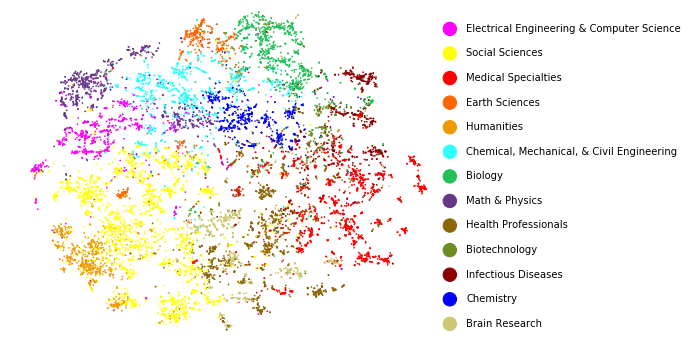

In [52]:
fig = plt.figure(figsize = (9.3, 5))
fig.subplots_adjust(left = 0.02, top=0.95, bottom=0.05)
ax1 = plt.subplot2grid((1,35), (0,0), rowspan=1, colspan=24)
plot_map_left(ax1, points, vname2vid)
ax2 = plt.subplot2grid((1,35), (0,24), rowspan=1, colspan=10)
plot_legend_right(ax2)
plt.show()
fig.savefig('map-new.pdf', dpi = 300)

Verify that the "Earth Sciences" micro cluster is actually closer to social sciences.

In [13]:
# journals in the earth sciences micro-clusters
check_jids = []
for i in range(len(points)):
    jid, x, y, hexc = points.iloc[i, :]
    if w2v.color2dis[w2v.hex2color[hexc]] == 'Earth Sciences':
        if x > 0.216 and x < 0.249 and y > 0.413 and y < 0.446:
            check_jids.append(jid)

In [14]:
check_df = mapping.loc[mapping.jid.isin(check_jids), :]

In [15]:
check_df.head()

,jid,jname,ucsd_jname,subd_id,subd_name,disc_id,disc_name,color
269,0AFFF318,Journal of Social Archaeology,JOURNAL OF SOCIAL ARCHAEOLOGY,468,Archeological Science,6,Earth Sciences,Mahogany
457,0A7499C3,Levant,Levant,468,Archeological Science,6,Earth Sciences,Mahogany
907,0518EF04,Estonian Journal of Archaeology,ESTONIAN JOURNAL OF ARCHAEOLOGY,468,Archeological Science,6,Earth Sciences,Mahogany
1273,06A3B2FB,Acta Archaeologica,ACTA ARCHAEOLOGICA,468,Archeological Science,6,Earth Sciences,Mahogany
1762,0643808F,International Journal of Nautical Archaeology,International Journal Of Nautical Archaeology,468,Archeological Science,6,Earth Sciences,Mahogany


In [16]:
vid2index = dict((vid, i) for i, vid in enumerate(model.index2word))
ixs = []
for jid in check_jids:
    ind = vid2index[jid]
    ixs.append(ind)
micro_earth_vec = np.mean(model.syn0[ixs, :].astype('float64'), axis = 0)
micro_earth_vec = micro_earth_vec / np.linalg.norm(micro_earth_vec)

In [17]:
earth_jids = mapping.loc[mapping['disc_name'] == 'Earth Sciences', 'jid'].tolist()
earth_main_cluster = [jid for jid in earth_jids if jid not in check_jids]
social_jids = mapping.loc[mapping['disc_name'] == 'Social Sciences', 'jid'].tolist()

In [18]:
print(len(check_jids))
print(len(earth_jids))
print(len(earth_main_cluster))
print(len(social_jids))

63
550
487
2978


In [19]:
dis_to_earth = {}
for jid in earth_main_cluster:
    if jid in vid2index:
        dis = cosine(micro_earth_vec, model.wv[jid])
        dis_to_earth[vid2vname[jid]] = dis
dis_to_social = {}
for jid in social_jids:
    if jid in vid2index:
        dis = cosine(micro_earth_vec, model.wv[jid])
        dis_to_social[vid2vname[jid]] = dis

In [20]:
len(dis_to_earth)

426

In [21]:
len(dis_to_social)

2712

In [40]:
top = 100
avg_dis_earth = sum(sorted(dis_to_earth.values())[:top])/top
avg_dis_social = sum(sorted(dis_to_social.values())[:top])/top
print('Center vector: the avg distance to the {} most closest earth journals is: {}'.format(top, avg_dis_earth))
print('Center vector: the avg distance to the {} most closest social journals is: {}'.format(top, avg_dis_social))

Center vector: the avg distance to the 100 most closest earth journals is: 0.40114432524747407
Center vector: the avg distance to the 100 most closest social journals is: 0.3469332850505834


In [41]:
top = 200
avg_dis_earth = sum(sorted(dis_to_earth.values())[:top])/top
avg_dis_social = sum(sorted(dis_to_social.values())[:top])/top
print('Center vector: the avg distance to the {} most closest earth journals is: {}'.format(top, avg_dis_earth))
print('Center vector: the avg distance to the {} most closest social journals is: {}'.format(top, avg_dis_social))

Center vector: the avg distance to the 200 most closest earth journals is: 0.4805506390783661
Center vector: the avg distance to the 200 most closest social journals is: 0.40183401802059343
